## Twitter  topic modeling

In this demo, we aim to discover Twitter topics related to vaccines via unsupervised topic modeling model LDA. LDA naturally assigns each tweet to clusters, and each cluster indicates a specific topic.  We use the collected Twitter data "tweets_1127_1130.csv" for presentaion. This dataset can be downloaded from
https://drive.google.com/drive/folders/1eDYECK9UnDqhuy7KkA6ISK4w8mD18GdQ?usp=sharing

We will go through the following steps in this notebook:

1) Active conversations collection

2) Tweets preprocessing

3) Topic modeling via LDA


--------


### 1 Active Conversation Collection

In this part, we filtered conversations that have more than 50 tweets for topic detection.

In [8]:

import pandas as pd
import numpy as np
from preprocessing import pipline_processing
from time import time
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


In [9]:
# change this to your own path
filepath = 'tweets1127_1130.csv'
dataframe = pd.read_csv(filepath)
dataframe = dataframe[['conversation_id', 'tweet']].dropna(axis=0, how='any', inplace=False)

conversation = dataframe['conversation_id'].drop_duplicates(keep='first', inplace=False)
print ('number of unique converation= ', len(conversation))


freq = dataframe.loc[:, 'conversation_id'].value_counts()
high_freq = freq[freq > 50]
dataframe = dataframe[dataframe['conversation_id'].isin(high_freq.index)]


tweets = dataframe['tweet'].drop_duplicates(keep='first', inplace=False)
conversation = dataframe['conversation_id'].drop_duplicates(keep='first', inplace=False)

print ('number of tweets contained in the selected conversation= ', len(tweets))
print ('number of conversation contained in the selected conversation= ', len(conversation))

# add some words to stopwords by hand 
STOPWORDS = set(stopwords.words('english'))
extras_stopwords = set(['vaccine','get','take','make','go','give','know','people','like','one','think','many','say', 'would', 'want','good'])
STOPWORDS = STOPWORDS | extras_stopwords

tweets = dataframe['tweet']
conversation_label = dataframe['conversation_id'].tolist()
df = pipline_processing(tweets, STOPWORDS)
data = df.tolist()

# need some time for text preprocessing

number of unique converation=  146798
number of tweets contained in the selected conversation=  31223
number of conversation contained in the selected conversation=  203


In [10]:

from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics


In [11]:
# visualizing the most important words in each topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 18), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=24)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

# 2 Detect Topics in Tweets 

Extracting tfidf features for LDA...
n_topics= 5 , ARI= 0.059185, NMI= 0.063029, Purity= 0.105398


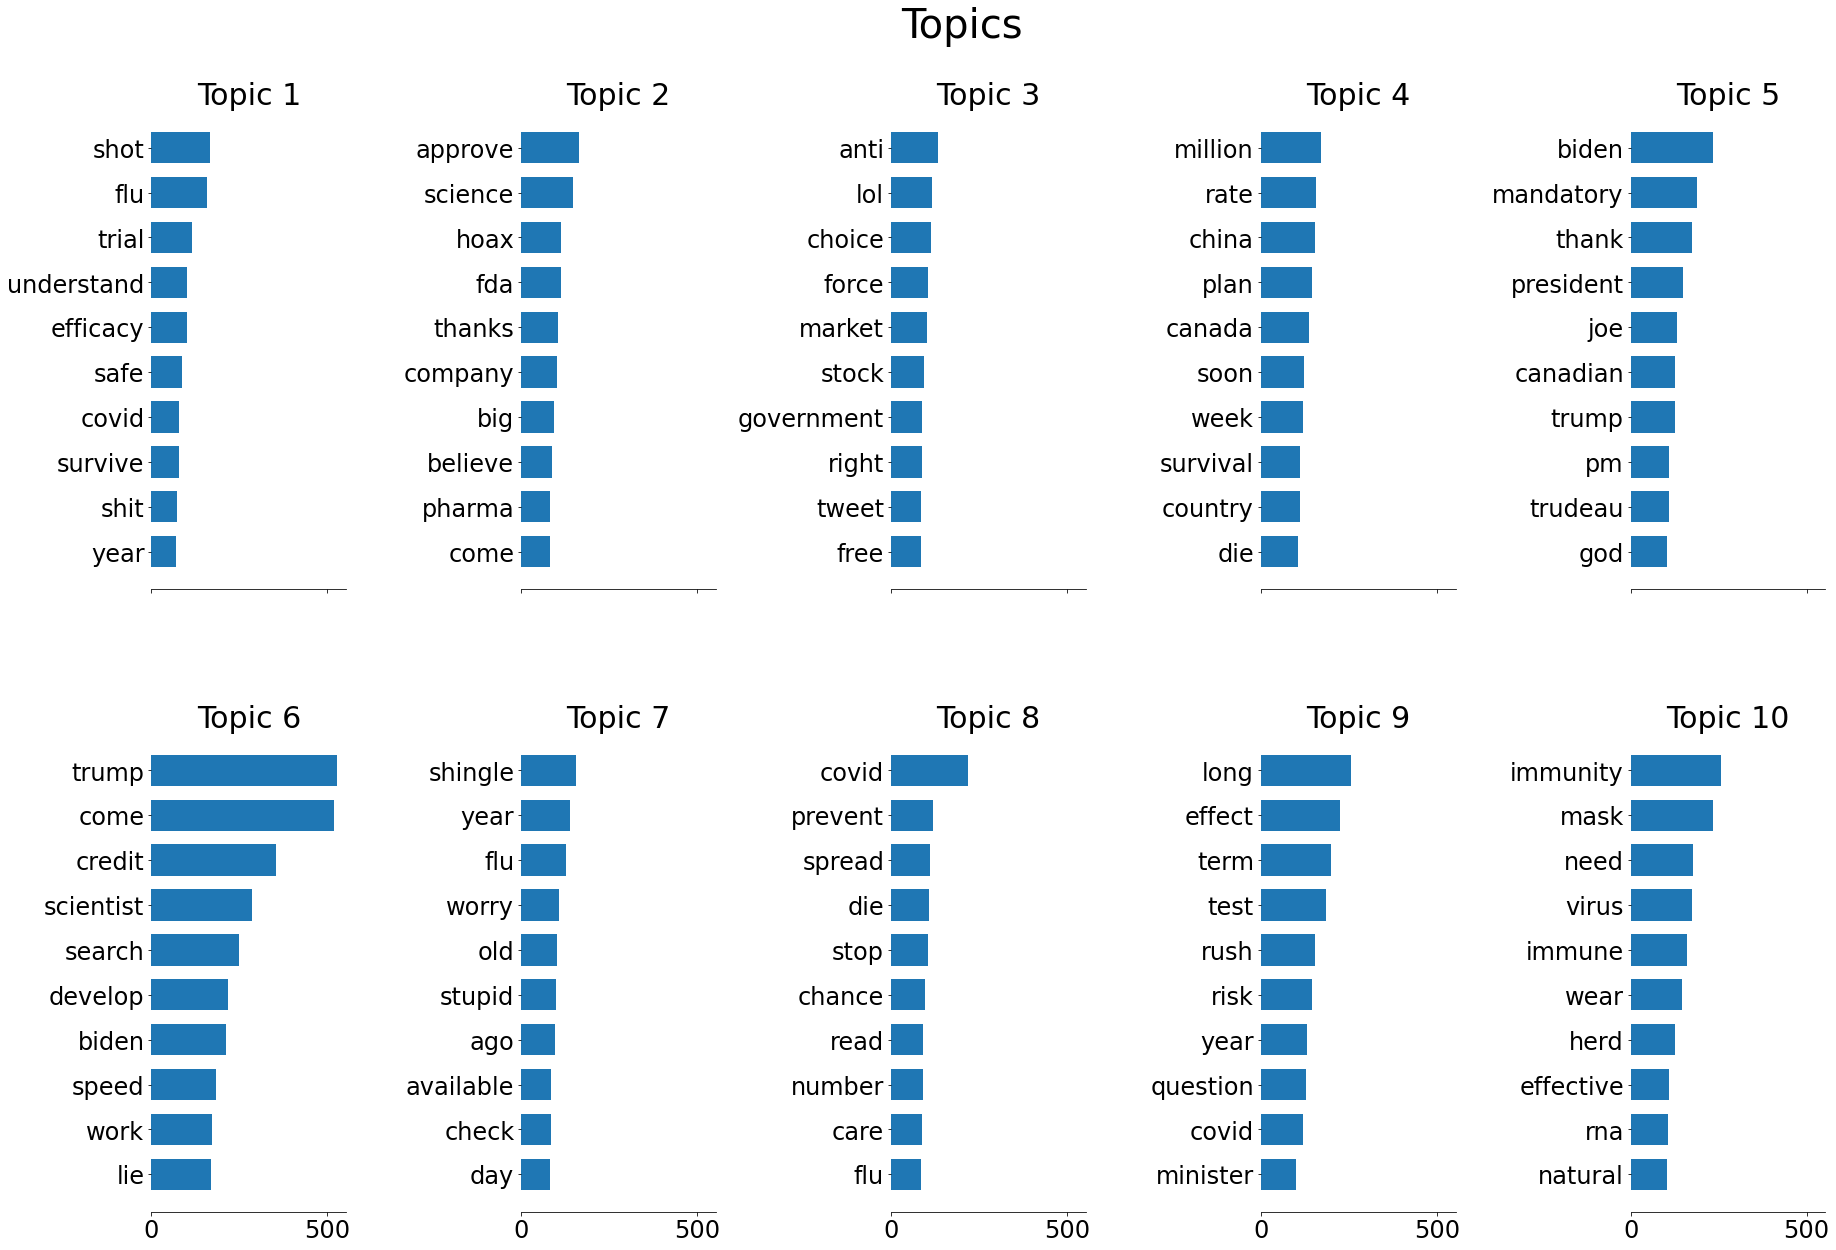

n_topics= 10 , ARI= 0.066951, NMI= 0.074826, Purity= 0.104599
n_topics= 20 , ARI= 0.069546, NMI= 0.085666, Purity= 0.109424
n_topics= 40 , ARI= 0.071459, NMI= 0.100846, Purity= 0.116839
n_topics= 80 , ARI= 0.079653, NMI= 0.122687, Purity= 0.119651
n_topics= 100 , ARI= 0.084267, NMI= 0.133628, Purity= 0.125372
n_topics= 120 , ARI= 0.088471, NMI= 0.133983, Purity= 0.128631
n_topics= 150 , ARI= 0.088229, NMI= 0.130008, Purity= 0.128759
n_topics= 200 , ARI= 0.091571, NMI= 0.101848, Purity= 0.118756


In [12]:
print("Extracting tfidf features for LDA...")
n_features = 1000
num_top_words = 10
n_topics_list = [5,10,20,40,80,100,120,150,200]

for n_topics in n_topics_list:

    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                    max_features=n_features,
                                    stop_words='english')
    # tfidf features
    tfidf = tfidf_vectorizer.fit_transform(data)

    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)


    # fit the lad model
    doclda = lda.fit_transform(tfidf)


    def purity_score(y_true, y_pred):
        # compute contingency matrix (also called confusion matrix)
        contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
        # return purity
        return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 


    lda_topic_label = np.argmax(doclda, axis=1)
    conversation_label = np.array(conversation_label)

    ARI_lda =  metrics.adjusted_mutual_info_score(conversation_label, lda_topic_label)  
    NMI_lda =  metrics.normalized_mutual_info_score(conversation_label, lda_topic_label)  
    Purity_lda = purity_score(conversation_label, lda_topic_label)
    
    # visualizing the most important num_top_words=10 words
    if n_topics == 10:
        tf_feature_names = tfidf_vectorizer.get_feature_names()
        plot_top_words(lda, tf_feature_names, num_top_words, 'Topics')
        
    print ('n_topics= %d , ARI= %f, NMI= %f, Purity= %f' %(n_topics, ARI_lda, NMI_lda, Purity_lda))


Clustering metrics are bad... Indicting that tweets in each conversation belong to different topics. 

We though it would be reasonable to assume that each conversation represent some topic, and the topic modeling model are supposed to cluster texts in the same conversation to the same cluster. But obviously this doesn't work.

# Group Tweet with Same Topic

We will later perform sentiment analysis on tweets within the same topic.

In [7]:
n_features = 1000
num_top_words = 10
n_topics = 10

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    # tfidf features
tfidf = tfidf_vectorizer.fit_transform(data)

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

# fit the lad model
# doclda is a np.ndarray
doclda = lda.fit_transform(tfidf)


cluster = np.argmax(doclda, axis = 1).reshape(-1,1)
cluster = cluster.astype(np.int32)
cluster_df = pd.DataFrame(data = cluster, index = None, columns = ['cluster'], dtype=int)

dataframe = [df, cluster_df]
dataframe = pd.concat(dataframe, axis=1)

groups = dataframe.groupby(['cluster'])

# save tweets of each topic to a csv file
for group in groups:
    cluster_id = group[0]
    df = group[1]['tweet']

    filename = './Topic_tweets/topic_{}.csv'.format(int(cluster_id))
    df.to_csv(filename, index = False)
print('Done!')

Done!
